In [1]:
import numpy as np
from numpy import pi
from numpy.fft import rfftfreq, rfft, irfft
from numpy.random import default_rng

from scipy import odr
import scipy.linalg as la
from scipy.optimize import least_squares
from scipy.stats import cumfreq, chi2, norm, probplot

from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

from thztools import thzgen, noiseamp, costfunlsq, ODR

The transfer function model function `tf_model` returns
 $$ H(\mathbf{\theta}; \omega) = \theta_0\exp(i\omega\theta_1),$$
 which rescales the input by $\theta_0$ and shifts it by $\theta_1$ (using the $-i\omega t$ sign convention). In the simulations, $\theta_0 = 1$ and $\theta_1 = 0$. The time-domain response function `td_model` applies this transfer function to a signal vector $x(t)$ for a given $\mathbf{\theta}$ and returns the resulting $y(t)$, as shown in the second cell for $\theta_0 = 0.5, \theta_1 = 1.0$.

In [2]:
def tf_model(_p, _w):
    return _p[0] * np.exp(-1j * _w * _p[1])

In [3]:
n = 256  # Number of samples
ts = 0.05  # Sampling time [ps]
t0 = 2.5  # Peak pulse time [ps]
fs = 1 / ts  # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0  # RNG seed
rng = default_rng(seed)

The ODRPACK documentation defines $X = X^* - \Delta^*$ and $Y = Y^* - E^*$, where the starred quantities indicate the true values.

In [4]:
n_sim = 250
p_opt = (0.5, 1)
f = rfftfreq(n, ts)


def td_model(_p, _x):
    _y = irfft(rfft(_x) * tf_model(_p, 2 * pi * f), n=n)
    return _y


mu, t = thzgen(n, ts, t0)
psi = td_model(p_opt, mu)
sigma_mu = noiseamp(sigma_parms, mu, ts)
sigma_psi = noiseamp(sigma_parms, psi, ts)
x_noise = sigma_mu * rng.standard_normal((n_sim, n))
y_noise = sigma_psi * rng.standard_normal((n_sim, n))

x = mu - x_noise
y = psi - y_noise

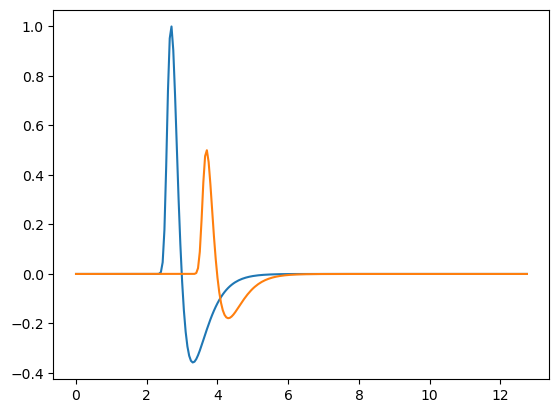

In [5]:
plt.plot(t, mu)
plt.plot(t, psi)
plt.show()

In [6]:
%%time

p_odr = np.empty((2, n_sim))
resnorm_odr = np.empty((n_sim,))
epsilon_odr = np.empty((n, n_sim))
delta_odr = np.empty((n, n_sim))
sigma_odr = np.empty((2, n_sim))
inv_condnum_odr = np.empty(n_sim)
info_odr = np.empty(n_sim, dtype=int)
stopreason_odr = np.empty(n_sim, dtype=object)

model = odr.Model(td_model)

for i in range(n_sim):
    sigma_x = noiseamp(sigma_parms, x[i, :], ts)
    sigma_y = noiseamp(sigma_parms, y[i, :], ts)
    delta_0 = x_noise[i, :]
    data = odr.RealData(x[i, :], y=y[i, :], sx=sigma_x, sy=sigma_y)
    fit = ODR(data, model, beta0=p_opt, delta0=delta_0)
    fit.set_job(del_init=1)
    result = fit.run()
    p_odr[:, i] = result.beta
    epsilon_odr[:, i] = result.eps
    delta_odr[:, i] = result.delta
    resnorm_odr[i] = result.sum_square
    sigma_odr[:, i] = result.sd_beta
    inv_condnum_odr[i] = result.inv_condnum
    info_odr[i] = result.info
    stopreason_odr[i] = result.stopreason
    if not result.info < 4:
        print(f"Fit did not converge at i = {i}")

cf_odr = cumfreq(resnorm_odr, 1000, defaultreallimits=(0, 1000))
gof_odr = cf_odr.lowerlimit + np.linspace(
    0, cf_odr.binsize * cf_odr.cumcount.size, cf_odr.cumcount.size
)
ecdf_odr = cf_odr.cumcount / n_sim

CPU times: user 840 ms, sys: 2.21 ms, total: 843 ms
Wall time: 844 ms


An exit code of less than 4 means that the solver has reached sum of squares convergence (1), parameter convergence (2), or both (3).

In [7]:
np.alltrue(info_odr < 4)

True

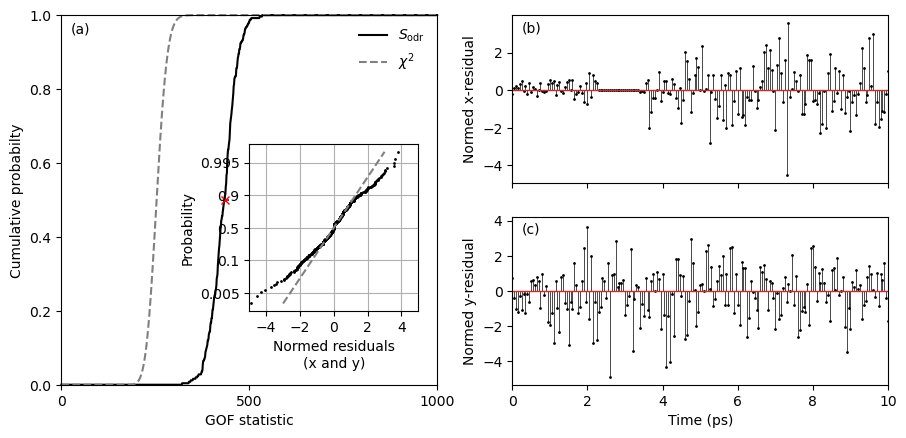

In [8]:
# Find the index of the median value
i_show = np.argsort(resnorm_odr)[len(resnorm_odr) // 2]
sigma_x = noiseamp(sigma_parms, x[i_show, :], ts)
sigma_y = noiseamp(sigma_parms, y[i_show, :], ts)
norm_res_eps = np.sqrt(512 / 254) * epsilon_odr[:, i_show] / sigma_y
norm_res_delta = np.sqrt(512 / 254) * delta_odr[:, i_show] / sigma_x
osm, osr = probplot(np.concatenate((norm_res_eps, norm_res_delta)), fit=False)

w, h = figaspect(0.45)
_, axd = plt.subplot_mosaic(
    [["CDF", "x-res"], ["CDF", "y-res"]], figsize=(w, h)
)

# Panel (a)
axd["CDF"].plot(
    gof_odr, ecdf_odr, 'k-', label=r'$S_\mathrm{odr}$', clip_on=False
)
axd["CDF"].plot(
    gof_odr,
    chi2.cdf(gof_odr, n - 2),
    '--',
    c='gray',
    label=r'$\chi^2$',
    clip_on=False,
)
axd["CDF"].plot(np.median(resnorm_odr), 0.5, 'rx')

axd["CDF"].legend(loc='upper right', frameon=False)
axd["CDF"].text(0.025, 0.95, '(a)', transform=axd["CDF"].transAxes)

axd["CDF"].set_xlim(0, 1000)
axd["CDF"].set_ylim(0, 1)

axd["CDF"].set_xticks([0, 500, 1000])
axd["CDF"].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axd["CDF"].set_xlabel('GOF statistic')
axd["CDF"].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axd["CDF"].inset_axes([0.5, 0.2, 0.45, 0.45])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-5, 5)
ins.set_ylim(norm.ppf([0.0005, 0.9995]))

ins.set_xticks(np.arange(-4, 4.5, 2))
ins.set_yticks(norm.ppf([0.005, 0.1, 0.5, 0.9, 0.995]))

ins.set_yticklabels(['0.005', '0.1', '0.5', '0.9', '0.995'])

ins.set_xlabel('Normed residuals\n(x and y)')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axd["x-res"].stem(
    t, norm_res_delta, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["x-res"].text(0.025, 0.9, '(b)', transform=axd["x-res"].transAxes)

axd["x-res"].set_xlim(0, 10)
# axd["x-res"].set_ylim(-4.5, 4.5)

axd["x-res"].set_xticklabels([])
axd["x-res"].set_ylabel('Normed x-residual')

# Panel (c)
markerline, stemlines, baseline = axd["y-res"].stem(
    t, norm_res_eps, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["y-res"].text(0.025, 0.9, '(c)', transform=axd["y-res"].transAxes)

axd["y-res"].set_xlim(0, 10)
# axd["y-res"].set_ylim(-4.5, 4.5)

axd["y-res"].set_xlabel('Time (ps)')
axd["y-res"].set_ylabel('Normed y-residual')

plt.show()

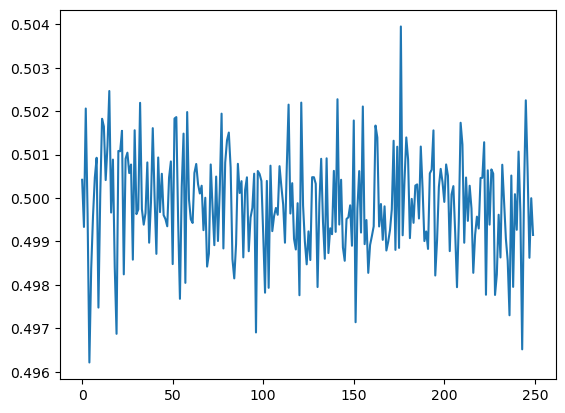

In [9]:
plt.plot(p_odr[0, :])
plt.show()

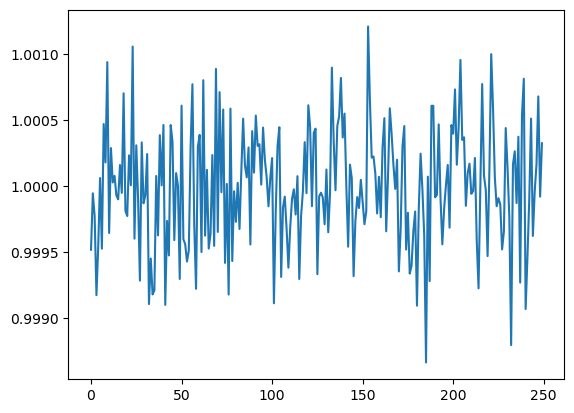

In [10]:
plt.plot(p_odr[1, :])
plt.show()

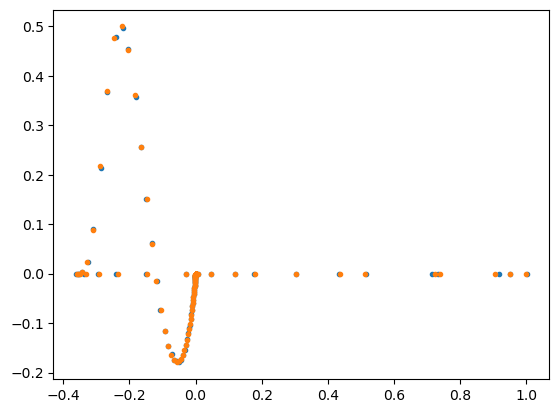

In [11]:
plt.plot(x[i_show, :], y[i_show, :], '.')
plt.plot(mu, psi, '.')
plt.show()

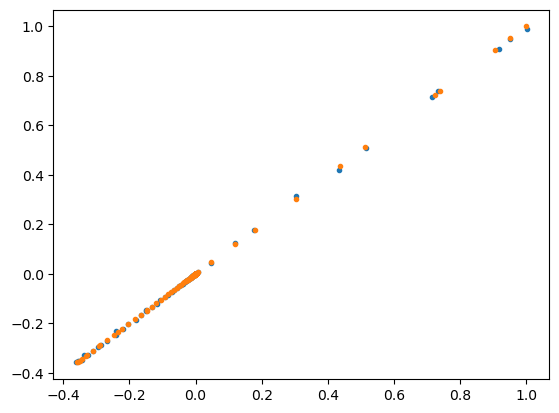

In [12]:
plt.plot(x[i_show, :], x[i_show + 1, :], '.')
plt.plot(mu, mu, '.')
plt.show()

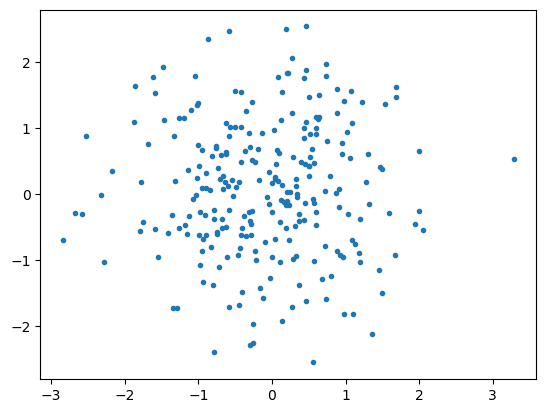

In [13]:
plt.plot((x[i_show, :] - mu) / sigma_mu, (y[i_show, :] - psi) / sigma_psi, '.')
plt.show()

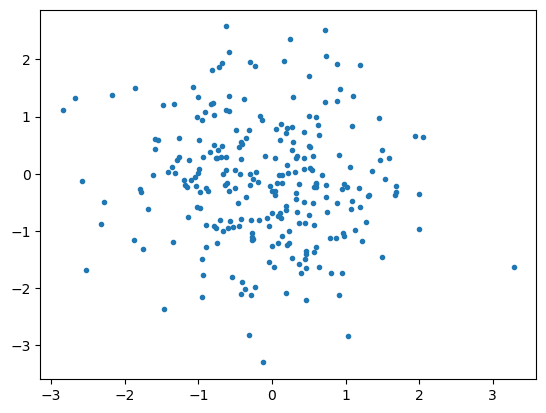

In [14]:
plt.plot(
    (x[i_show, :] - mu) / sigma_mu, (x[i_show + 1, :] - mu) / sigma_mu, '.'
)
plt.show()

In [15]:
print(
    f"Amplitude parameter estimates: "
    f"{np.mean(p_odr[0, :]):.3f} ± {np.std(p_odr[0, :]):.3f}"
)
print(
    f"Delay parameter estimates:     "
    f"({np.mean(1e3 * p_odr[1, :]):.1f} ± {1e3 * np.std(p_odr[1, :]):.1f}) fs"
)
print(
    f"Mean uncertainty estimate for amplitude parameter: "
    f"{np.mean(sigma_odr[0, :]):.4f}"
)
print(
    f"Mean uncertainty estimate for delay parameter:     "
    f"{1e3 * np.mean(sigma_odr[1, :]):.1f} fs"
)
print(
    f"Standard deviation of the amplitude parameter uncertainty estimate: "
    f"{np.std(sigma_odr[0, :]):.2g}"
)
print(
    f"Standard deviation of the delay parameter uncertainty estimate:     "
    f"{1e3 * np.std(sigma_odr[1, :]):.2g} fs"
)

Amplitude parameter estimates: 0.500 ± 0.001
Delay parameter estimates:     (1000.0 ± 0.4) fs
Mean uncertainty estimate for amplitude parameter: 0.0018
Mean uncertainty estimate for delay parameter:     0.5 fs
Standard deviation of the amplitude parameter uncertainty estimate: 7.2e-05
Standard deviation of the delay parameter uncertainty estimate:     0.042 fs


In [16]:
%%time


def lsq_model(_p, _w):
    return _p[0] * np.exp(1j * _w * _p[1])


p_tls = np.empty((2, n_sim))
resnorm_tls = np.empty((n_sim,))
residual_tls = np.empty((n, n_sim))
cv_tls = np.empty((2, 2, n_sim))
sigma_tls = np.empty((2, n_sim))

for i in range(n_sim):
    sigma_x = noiseamp(sigma_parms, x[i, :], ts)
    sigma_y = noiseamp(sigma_parms, y[i, :], ts)
    result = least_squares(
        lambda _p: costfunlsq(
            lsq_model, _p, x[i, :], y[i, :], sigma_x, sigma_y, ts
        ),
        p_opt,
        jac='2-point',
    )
    p_tls[:, i] = result.x
    residual_tls[:, i] = result.fun
    resnorm_tls[i] = 2 * result.cost
    _, r = np.linalg.qr(result.jac)
    r_inv = np.linalg.inv(r)
    cv_tls[:, :, i] = r_inv @ r_inv.T
    sigma_tls[:, i] = np.sqrt(np.diag(cv_tls[:, :, i]))
    if not result.success:
        print(f"Fit did not converge at i = {i}")

CPU times: user 30min 1s, sys: 3min 33s, total: 33min 34s
Wall time: 8min 16s


In [17]:
cf_tls = cumfreq(resnorm_tls, 1000, defaultreallimits=(0, 1000))
gof_tls = cf_tls.lowerlimit + np.linspace(
    0, cf_tls.binsize * cf_tls.cumcount.size, cf_tls.cumcount.size
)
ecdf_tls = cf_tls.cumcount / n_sim

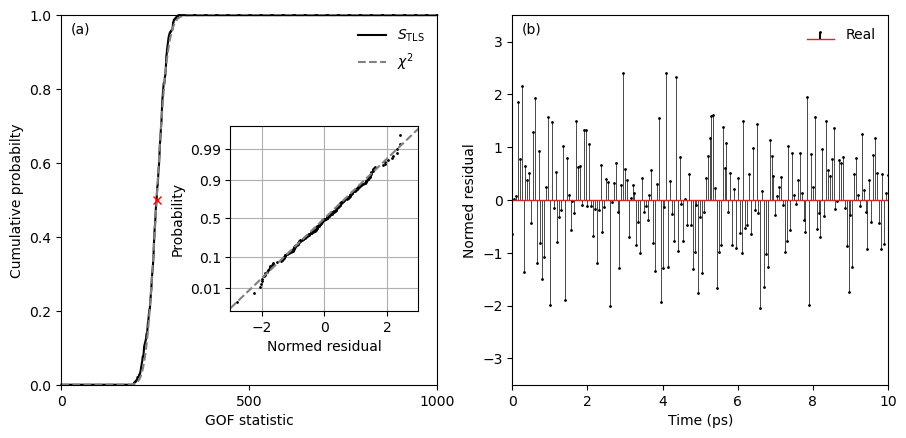

In [18]:
# Find the index of the median value
i_show = np.argsort(resnorm_tls)[len(resnorm_tls) // 2]
osm, osr = probplot(residual_tls[:, i_show], fit=False)

w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

# Panel (a)
axs[0].plot(gof_tls, ecdf_tls, 'k-', label=r'$S_\mathrm{TLS}$', clip_on=False)
axs[0].plot(
    gof_tls,
    chi2.cdf(gof_tls, n - 2),
    '--',
    c='gray',
    label=r'$\chi^2$',
    clip_on=False,
)
axs[0].plot(np.median(resnorm_tls), 0.5, 'rx')

axs[0].legend(loc='upper right', frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 1)

axs[0].set_xticks([0, 500, 1000])
axs[0].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axs[0].set_xlabel('GOF statistic')
axs[0].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axs[0].inset_axes([0.45, 0.2, 0.5, 0.5])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-3, 3)
ins.set_ylim(norm.ppf([0.001, 0.999]))

ins.set_xticks([-2, 0, 2])
ins.set_yticks(norm.ppf([0.01, 0.1, 0.5, 0.9, 0.99]))

ins.set_yticklabels(['0.01', '0.1', '0.5', '0.9', '0.99'])

ins.set_xlabel('Normed residual')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axs[1].stem(
    t, residual_tls[:, i_show], linefmt='k-', markerfmt='.', label='Real'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axs[1].legend(loc='upper right', frameon=False)
axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlim(0, 10)
axs[1].set_ylim(-3.5, 3.5)

axs[1].set_xlabel('Time (ps)')
axs[1].set_ylabel('Normed residual')

plt.show()